# Lab 3
This lab will focus on reviewing concepts of dplyr and exploratory data analysis, then explore animal shelter outcomes, then end with exercises from section 7 and 10 from your book.

## Table of Contents
* [Review](#Review)
* [Explore](#Explore)
* [Exercises](#Exercises)

In [1]:
library(tidyverse)
#These packages are specific to the explore section:
library(lubridate)
library(rpart)
library(randomForest)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



## Review

### General HW Hints

* Read the question carefully! 
    * Is the questions asking for number? vector? table?
    * Are the specific conditions that need to be filtered?
* Test the output!
    * If you need to create a variable 'table1', after you're done double check that everything looks good in table1
    * If you have a condition that should be looking for the first letter of a string, double check with a simple string that it is actually taking the first letter.
* Lecture notes will be able to give you 99% of the functions you will need to answer the questions, no new packages should be needed unless stated.
* In general, don't hard code values, assume the data the professor tests your code on will change (e.g. pulling columns that start with "X" would not need something like this: `data[c(3,6,10,11)]` )

### Function Review

Here are some the important functions I picked out from your reading and lecture notes, this isn't meant to be exhaustive! Simple examples are given using the mtcars data set (in tidyverse).

* names(): Gives you the names of data frames in a vector of strings
```{r}
#Get the column names of the data set
names(mtcars)
```
* filter(): Filters the entire table by a condition or set of conditions
```{r}
#Filter to cars with only 6 cylinders more than 110 horsepower
mtcars %>% filter((cyl == 6) & (hp > 110))
```
* arrange(): Sorts the table output by specific columns (use desc(varname) for descending order)
```{r}
#Sort the cars by horsepower in descending order
mtcars %>% arrange(desc(hp))
```
* select(): Returns a new table with only the selected columns (can rename with newname = oldname)
```{r}
#Only select mpg and hp, rename hp to horseys
mtcars %>% select(mpg, horseys = hp)
```
* summarise(): Takes your existing table and returns a smaller table aggregated based on a function
```{r}
#Find the median hp, max mpg, and mean cylinder
mtcars %>% summarize(med_hp = median(hp), mx_mpg = max(mpg), avg_cyl = mean(cyl))
```
* group_by(): Groups the table by a categorical variable(s), normally used with summarize
```{r}
#Average hp by number of cylinders
mtcars %>% group_by(cyl) %>% summarize(avg_hp = mean(hp))
```
* mutate(): Used to create new columns based on existing ones (use transmute() if you only want the column you are creating)
```{r}
#Create a column for the mpg per cylinder
#Returns a whole table
mtcars %>% mutate(mpg_cyl = mpg / cyl)
#Returns just mpg_cyl
mtcars %>% transmute(mpg_cyl = mpg / cyl)
```
* %% (modulus): Gives you the remainder of division
```{R}
#Find the even numbers in a list
ls = c(1,2,3,4,5,6,7)
#If theres no remainder, it's even (TRUE)
evn = ifelse(ls %% 2 == 0, TRUE, FALSE)
#Subset the list by the TRUE's
ls[evn]
```
* %/% (integer division): Basically just chops off the decimal of division
```{r}
#4/3 is not 1.333, it's just 1
4 %/% 3
```
* count(): Gives a count of each value for a variable in a data frame
```{r}
#Get a count of the number of cylinder and gear combinations in the data set
mtcars %>% count(cyl, gear)
```

Ranking is a really common operation you do when analyzing data, here are the main ranks that were covered in class so far:
* `min_rank(v)`: rank the entries of `v` in ascending order, so the smallest entry gets a 1, etc. Ties get the same rank.
* `row_number(v)`: same as `min_rank(v)`, but every entry gets its own rank.
* `dense_rank(v)`: same as `min_rank(v)`, but no gaps created between the ranks.
* `percent_rank()`: ranks expressed in percentiles.
* `cume_dist(v)`: fraction of entries `<=` each entry of `v`.
* `ntile(v)`: group entries of `v` into buckets and report which bucket

In [ ]:
#Let's test out each of the ranks to make sure we understand each
v = c(1,2,4,4,3)
cat("Original:   ", v, "\n")
cat("Min Rank:   ",min_rank(v),"\n")
cat("Row Number:   ",row_number(v),"\n")
cat("Dense Rank:   ",dense_rank(v),"\n")
cat("Percent Rank:   ",percent_rank(v),"\n")
cat("Cum. Dist.:   ",cume_dist(v),"\n")
cat("ntile:   ",ntile(v,n=2),"\n")

Here is a list of some of the important summary functions that exist in R:
* Center: `mean(), median()`
* Spread: `sd(), IQR(), mad()`
* Range: `min(), max(), quantile()`
* Position: `first(), last(), nth()`
* Count: `n(), n_distinct()`
* Logical: `any(), all()`

In [ ]:
#Here are a few examples using these summary functions
#Do any of the cars in mtcars have more than 120 horsepower?
any(mtcars$hp>120)
#Do all of the cars have more than 20 horsepower?
all(mtcars$hp>20)

#Huzzah

In [ ]:
#What if I want to know the first or last entry of some vector?
x = c(8,2,3,4)
cat("First: ", first(x), "\n")
cat("Last: ",last(x), "\n")

Using the image below, what values do you expect at each quantile?
![Normal](normal_dist.png)

In [ ]:
#If I define a vector, x, of 1000 random normal values of mean 10 and sd 2
x = rnorm(1000, mean=10, sd=2)
#What values do you expect as you change these?
quantile(x, 0.5)

By default the pipe inserts the output of the LHS command as the first argument to the RHS command:
```{r}
f() %>% g()  # same as g(f())
```
If you need to use the LHS output elsewhere in the command, the `.` character can be used to place it there:
```{r}
f() %>% g(1, .)  # same as g(1, f())
```

## Explore

The following analysis is based on data and work that can be found on Kaggle. We'll be using data released from the Austin Animal Center around outcomes of shelter animals. We'll use this data to explore shelter animals in the area and also try to predict the outcome (adopted, returned to owner, etc.) of the animal based on the data we have using a random forest.

**Note:** *This content uses some functions and techniques that are outside the scope of the course, it is meant to show you how what you're learning can be used in interesting problems.*

---

Let's first load the data in, do a bit of cleanup, and then take a peek to how the data looks. Notice that all of the data is being treated as a string (chr), even date and animal age, so we'll have to address that at some point.

In [2]:
#Load in the data
train = read.csv('train.csv', stringsAsFactors = F)
test = read.csv('test.csv', stringsAsFactors = F)

#Tidy the data up a bit
# Rename the ID column so train & test match
names(train)[1] = 'ID'
# And change ID in test to character
test$ID = as.character(test$ID)
# Combine test & training data
full = bind_rows(train, test)
#Let's take peek
str(full)

'data.frame':	38185 obs. of  10 variables:
 $ ID            : chr  "A671945" "A656520" "A686464" "A683430" ...
 $ Name          : chr  "Hambone" "Emily" "Pearce" "" ...
 $ DateTime      : chr  "2014-02-12 18:22:00" "2013-10-13 12:44:00" "2015-01-31 12:28:00" "2014-07-11 19:09:00" ...
 $ OutcomeType   : chr  "Return_to_owner" "Euthanasia" "Adoption" "Transfer" ...
 $ OutcomeSubtype: chr  "" "Suffering" "Foster" "Partner" ...
 $ AnimalType    : chr  "Dog" "Cat" "Dog" "Cat" ...
 $ SexuponOutcome: chr  "Neutered Male" "Spayed Female" "Neutered Male" "Intact Male" ...
 $ AgeuponOutcome: chr  "1 year" "1 year" "2 years" "3 weeks" ...
 $ Breed         : chr  "Shetland Sheepdog Mix" "Domestic Shorthair Mix" "Pit Bull Mix" "Domestic Shorthair Mix" ...
 $ Color         : chr  "Brown/White" "Cream Tabby" "Blue/White" "Blue Cream" ...


Since we eventually are going to want to predict the outcome of each animal, let's take a look at the outcome types by animal and make sure we have about even proportions of each class.

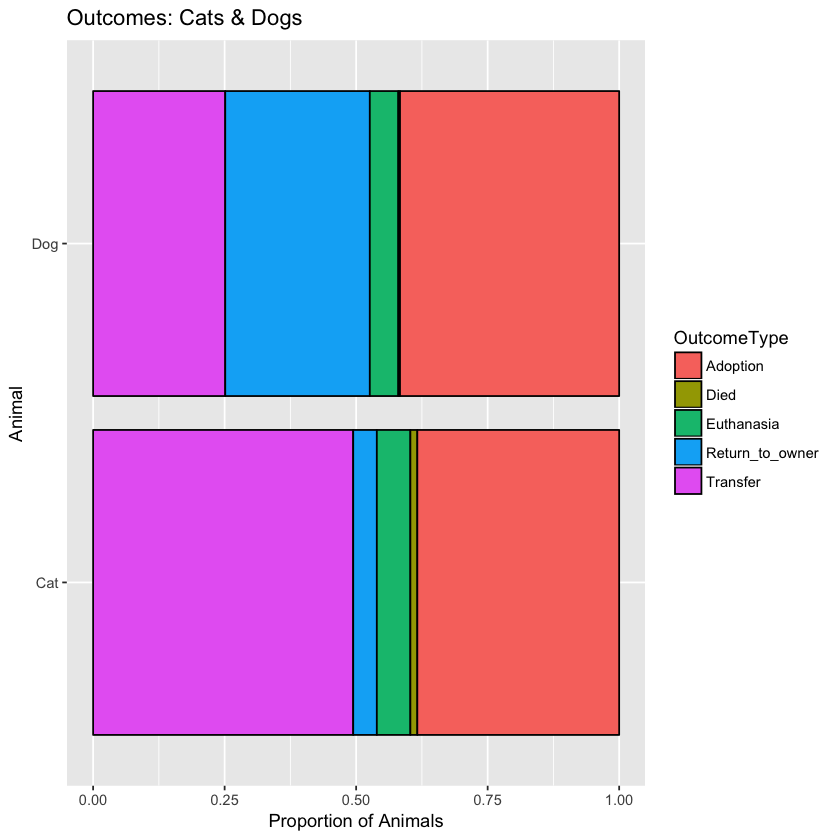

In [3]:
# We'll eventually want to predict outcome type, so let's make a table of the counts of each outcome
outcomes = full %>% filter(is.na(OutcomeType) == FALSE) %>%
  group_by(AnimalType, OutcomeType) %>%
  summarise(num_animals = n())

#Now let's visulize data and see what we find
ggplot(outcomes, aes(x = AnimalType, y = num_animals, fill = OutcomeType)) +
  geom_bar(stat = 'identity', position = 'fill', colour = 'black') +
  coord_flip() +
  labs(y = 'Proportion of Animals',
       x = 'Animal',
       title = 'Outcomes: Cats & Dogs')

Now, let's get the age of the animal in a format that we can use, as you can see below the current format is pretty bad for analysis.

In [ ]:
#Why would someone store data like this!?
factor(full$AgeuponOutcome)[1:10]

In [4]:
#Lots of manipulations to fix this bad format

# Get the time value:
full$TimeValue = sapply(full$AgeuponOutcome,function(x) strsplit(x, split = ' ')[[1]][1])
# Now get the unit of time:
full$UnitofTime = sapply(full$AgeuponOutcome,function(x) strsplit(x, split = ' ')[[1]][2])
# Fortunately any "s" marks the plural, so we can just pull them all out
full$UnitofTime = gsub('s', '', full$UnitofTime)
full$TimeValue  = as.numeric(full$TimeValue)
full$UnitofTime = as.factor(full$UnitofTime)

#Now we convert the age into days
# Make a multiplier vector
multiplier = ifelse(full$UnitofTime == 'day', 1,
              ifelse(full$UnitofTime == 'week', 7,
              ifelse(full$UnitofTime == 'month', 30,
              ifelse(full$UnitofTime == 'year', 365, NA))))
full$AgeinDays = full$TimeValue * multiplier

In [ ]:
#Ah, now we can finally use this
summary(full$AgeinDays)

In [5]:
#These steps will fix the name field, fix the gender, get the time in a format that's more useable, and clean up some of the remaining fields
# Replace blank names with "Nameless"
full$Name = ifelse(nchar(full$Name)==0, 'Nameless', full$Name)
# Make a name v. no name variable
full$HasName[full$Name == 'Nameless'] = 0
full$HasName[full$Name != 'Nameless'] = 1

# Replace blank sex with most common
full$SexuponOutcome = ifelse(nchar(full$SexuponOutcome)==0,'Spayed Female', full$SexuponOutcome)

# Extract time variables from date (uses the "lubridate" package)
full$Hour    = hour(full$DateTime)
full$Weekday = wday(full$DateTime)
full$Month   = month(full$DateTime)
full$Year    = year(full$DateTime)
# Time of day may also be useful
full$TimeofDay = ifelse(full$Hour > 5 & full$Hour < 11, 'morning',
                  ifelse(full$Hour > 10 & full$Hour < 16, 'midday',
                  ifelse(full$Hour > 15 & full$Hour < 20, 'lateday', 'night')))
# Put factor levels into the order we want
full$TimeofDay = factor(full$TimeofDay,
                    levels = c('morning', 'midday',
                               'lateday', 'night'))

#We just need to clean up and create a few more fields which we'll use in the prediction step
# Use "grepl" to look for "Mix"
full$IsMix = ifelse(grepl('Mix', full$Breed), 1, 0)
# Split on "/" and remove " Mix" to simplify Breed
full$SimpleBreed = sapply(full$Breed,function(x) gsub(' Mix', '',strsplit(x, split = '/')[[1]][1]))
# Use strsplit to grab the first color
full$SimpleColor = sapply(full$Color,function(x) strsplit(x, split = '/| ')[[1]][1])
# Use "grepl" to look for sex
full$Sex = ifelse(grepl('Male', full$SexuponOutcome), 'Male',ifelse(grepl('Unknown', full$Sex), 'Unknown', 'Female'))

In [ ]:
#Now let's see if the time if the time of day impacts the outcome variable at all
daytimes = full[1:26729, ] %>%
  group_by(AnimalType, TimeofDay, OutcomeType) %>%
  summarise(num_animals = n())

ggplot(daytimes, aes(x = TimeofDay, y = num_animals, fill = OutcomeType)) +
  geom_bar(stat = 'identity', position = 'fill', colour = 'black') +
  facet_wrap(~AnimalType) +
  coord_flip() +
  labs(y = 'Proportion of Animals',
       x = 'Animal',
       title = 'Outcomes by Time of Day: Cats & Dogs')

In [ ]:
#Let's take a look at if the animal is neutered and if that impacts outcomes
# Use "grepl" to look for "Intact"
full$Intact = ifelse(grepl('Intact', full$SexuponOutcome), 1,ifelse(grepl('Unknown', full$SexuponOutcome), 'Unknown', 0))
# Setup data
intact = full[1:26729, ] %>%
  group_by(AnimalType, Intact, OutcomeType) %>%
  summarise(num_animals = n())
# Plot
ggplot(intact, aes(x = Intact, y = num_animals, fill = OutcomeType)) +
  geom_bar(stat = 'identity', position = 'fill', colour = 'black') +
  facet_wrap(~AnimalType) +
  coord_flip() +
  labs(y = 'Proportion of Animals',
       x = 'Animal',
       title = 'Outcomes by Intactness: Cats & Dogs')

In [ ]:
# This code fills in missing values of AgeinDays by predicting them with other variables
age_fit = rpart(AgeinDays ~ AnimalType + Sex + Intact + SimpleBreed + HasName, data = full[!is.na(full$AgeinDays), ],method = 'anova')
# Impute predicted age values where missing using "predict"
full$AgeinDays[is.na(full$AgeinDays)]  = predict(age_fit, full[is.na(full$AgeinDays), ])

In [ ]:
#Let's see if the age makes a large difference in if an animal is adopted
# Use the age variable to make a puppy/kitten variable
full$Lifestage[full$AgeinDays < 365] = 'baby'
full$Lifestage[full$AgeinDays >= 365] = 'adult'
full$Lifestage <- factor(full$Lifestage)
#Plot
ggplot(full[1:26729, ], aes(x = Lifestage, fill = OutcomeType)) +
  geom_bar(position = 'fill', colour = 'black') +
  labs(y = 'Proportion', title = 'Animal Outcome: Babies versus Adults')

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#These steps take quite a bit of time to run (~20 min) so only run them if you have a bit of time!
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# #Alright, it's time to use a Random Forest model to predict the outcome of an animal
# factorVars <- c('Name','OutcomeType','OutcomeSubtype','AnimalType',
#                 'SexuponOutcome','AgeuponOutcome','SimpleBreed','SimpleColor',
#                 'HasName','IsMix','Intact','Sex','TimeofDay','Lifestage')

# full[factorVars] <- lapply(full[factorVars], function(x) as.factor(x))
    
# # Split up train and test data
# train <- full[1:26729, ]
# test  <- full[26730:nrow(full), ]

# # Build the model
# rf_mod = randomForest(OutcomeType ~ AnimalType+AgeinDays+Intact+HasName+Hour+Weekday+TimeofDay+SimpleColor+IsMix+Sex+Month,
#   data = train,
#   ntree = 600,
#   importance = TRUE)

# # Show model error
# plot(rf_mod, ylim=c(0,1))
# legend('topright', colnames(rf_mod$err.rate), col=1:6, fill=1:6)

In [ ]:
# #One helpful part of Random Forests is that they inherently give you the importance of each variable, let's take a see what variables are most predictive!
# # Get importance
# importance    = importance(rf_mod)
# varImportance = data.frame(Variables = row.names(importance),Importance = round(importance[ ,'MeanDecreaseGini'],2))

# # Create a rank variable based on importance
# rankImportance <- varImportance %>%
#   mutate(Rank = paste0('#',dense_rank(desc(Importance))))

# # Use ggplot2 to visualize the relative importance of variables
# ggplot(rankImportance, aes(x = reorder(Variables, Importance),y = Importance)) +
#   geom_bar(stat='identity', colour = 'black') +
#   geom_text(aes(x = Variables, y = 0.5, label = Rank),hjust=0, vjust=0.55, size = 4, colour = 'lavender',fontface = 'bold') +
#   labs(x = 'Variables', title = 'Relative Variable Importance') +
#   coord_flip()

## Exercises

### Dplyr gone haywire

In [ ]:
# Using mtcars and in one line of code, find the mean horsepower for each cylinder type for only cars with 
# higher than 20 mpg. Output only the max mean of this subset of data.

In [ ]:
# Using mtcars and in one line of code, Find the average horsepower of cars that are in the top 20% based on mpg

### Section 7

In [ ]:
# Explore the distribution of price. Do you discover anything unusual or surprising?

In [ ]:
# How many diamonds are 0.99 carat? How many are 1 carat? What do you think is the cause of the difference?

In [ ]:
# What happens to missing values in a histogram? What happens to missing values in a bar chart? Why is there a difference?

In [ ]:
# What does na.rm = TRUE do in mean() and sum()?

In [ ]:
# How could you rescale plot below to more clearly show the distribution of cut within colour, or colour within cut?
diamonds %>% count(color, cut) %>% ggplot(mapping = aes(x = color, y = cut)) + geom_tile(mapping = aes(fill = n))

### Section 10

In [ ]:
# How can you tell if an object is a tibble?

In [ ]:
# Compare and contrast the following operations on a data.frame and equivalent tibble. 
# What is different? Why might the default data frame behaviors cause you frustration?
df <- data.frame(abc = 1, xyz = "a")
df$x
df[, "xyz"]
df[, c("abc", "xyz")]

In [ ]:
#If you have the name of a variable stored in an object, e.g. var <- "mpg", how can you extract the
# reference variable from a tibble?

In [ ]:
#Practice referring to non-syntactic names in the following data frame by:
# 1. Extracting the variable called 1.
# 2. Plotting a scatterplot of 1 vs 2.
# 3. Creating a new column called 3 which is 2 divided by 1.
# 4. Renaming the columns to one, two and three.
annoying <- tibble(
`1` = 1:10,
`2` = `1` * 2 + rnorm(length(`1`))
)

In [ ]:
# What does tibble::enframe() do? When might you use it?